In [1]:
from tsfresh_feature_extraction import *

In [2]:
set_seed(612)

In [3]:
device=CFG.device
CFG.epoches=350

In [4]:
train_extracted_minmax_large=np.load("./numpy/train_extracted_minmax_train_0322.npy")
test_extracted_minmax_large=np.load("./numpy/test_extracted_minmax_train_0322.npy")
device=CFG.device
CFG.epoches=350
longlist=np.concatenate((train_extracted_minmax_large,test_extracted_minmax_large),axis=\
                        0)[:,np.random.permutation(100)]
train_extracted_minmax_large,test_extracted_minmax_large=np.vsplit(longlist,np.array([24020]))
device=CFG.device
train_dataset_expend_encoded = AircraftDataset_expend_feature_extraction(df_train, train_label, torch.FloatTensor(train_extracted_minmax_large),False)
train_encoded_loader = DataLoader(
    train_dataset_expend_encoded,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
)
test_dataset = AircraftDataset_no_expend_feature_extraction(df_test, test_label, torch.FloatTensor(test_extracted_minmax_large))
test_encoded_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False)
for train_data in train_encoded_loader:None
for test_data in test_encoded_loader:None

# no cls

In [5]:
def fit_his_unit(train_loader,path, RESUME=False, shared=True, attention=True, expand=True):
    model=AML_model(100,100,100,128,2,20,shared=shared,attention=attention,expand = expand).to(device)
    #model=AML_model(99,99,99).to(device)
    optimizer = getattr(torch.optim, CFG.optimizer)(model.parameters(), lr=CFG.lr)  # 优化器
    scheduler = getattr(torch.optim.lr_scheduler, CFG.scheduler)(optimizer, gamma=CFG.sc_Gamma)  # 指数型学习率
    start_epoch=-1
    if RESUME:
        path_checkpoint = path+'/ckpt.pth'   # 断点路径
        checkpoint = torch.load(path_checkpoint)  # 加载断点

        model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数

        optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
        start_epoch = checkpoint['epoch']  # 设置开始的epoch
        scheduler.load_state_dict(checkpoint['scheduler'])


    for epoch in range(start_epoch+1,CFG.epoches):
        for data in train_loader:
            if attention:
                pred_batch = model(data["input"].to(device))[0]
            elif not attention:
                pred_batch = model(data["input"].to(device))
            target_batch = data["RUL"].unsqueeze(-1).to(device)
            loss = F.mse_loss(pred_batch, target_batch.float())
        # loss = loss_function(pred_batch, target_batch, train_data, test_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        # scheduler.step(loss,last_loss)
        # last_loss = loss
        if CFG.print_training_process and epoch % 100 == 0:
            print(f"epoch:{epoch}, loss:{loss.item()},lr:{optimizer.state_dict()['param_groups'][0]['lr']}")
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'scheduler': scheduler.state_dict()
            }
            if not os.path.isdir(path):
                os.mkdir(path)
            torch.save(checkpoint,
                       path+'/ckpt.pth')
        if loss.mean() < CFG.jump_out_value:
            save_model_weights(model, "model_his.pt",
                               cp_folder=path)
            break
        elif epoch == (CFG.epoches - 1):
            print(f"epoch:{epoch}, loss:{loss.item()}")
            save_model_weights(model, "model_his.pt",
                               cp_folder=path)

In [28]:
fit_his_unit(train_encoded_loader,"./model_checkpoints_at", RESUME=False, shared=False, attention=True,expand=False)

epoch:0, loss:4683.556640625,lr:0.09890548353295386
epoch:100, loss:88.21176147460938,lr:0.032904660865335375

 -> Saving weights to ./model_checkpoints_at\model_his.pt



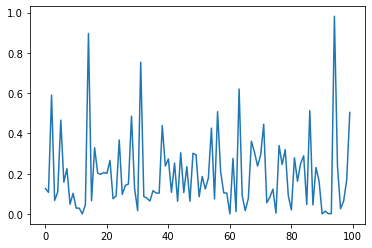

In [29]:
aml_model=AML_model(100,100,100,128,2,20,shared=False,attention=True,expand = False).to(device)
aml_model.load_state_dict(torch.load("./model_checkpoints_at/model_his.pt"))
plt.plot(aml_model(train_data["input"].to(device))[1].cpu().detach().numpy())

In [30]:
pred_1=[]
for idx,test_data in enumerate(test_encoded_loader):
    pred_1_q=aml_model(test_data["input"].to(device))[0].item()
    pred_1.append(pred_1_q)
#RUL
path = DATA_PATH+'RUL.csv'
RUL_frame = pd.read_csv(path, header=None)
RUL = RUL_frame.values[:, 0]
RUL_y=pd.Series(RUL)
RUL_y.index+=1
np.sum(np.ceil((abs(np.array(pred_1)-RUL))))#目测结果

2353.0

# have cls

## mode part fix (get fix)

In [31]:
def fit_AML_model2_cls(train_loader,path, RESUME=False):
    model=AML_model2(100,100,100,128,2,20).to(device)
    #model=AML_model(99,99,99).to(device)
    optimizer = getattr(torch.optim, CFG.optimizer)(model.parameters(), lr=0.001,weight_decay=0.001)  # 优化器
    scheduler = getattr(torch.optim.lr_scheduler, CFG.scheduler)(optimizer, gamma=CFG.sc_Gamma)  # 指数型学习率
    start_epoch=-1
    if RESUME:
        path_checkpoint = path+'/ckpt_aml_cls.pth'   # 断点路径
        checkpoint = torch.load(path_checkpoint)  # 加载断点

        model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数

        optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
        start_epoch = checkpoint['epoch']  # 设置开始的epoch
        #scheduler.load_state_dict(checkpoint['scheduler'])


    for epoch in range(start_epoch+1,CFG.epoches):
        for data in train_loader:
            y_pred,cls_pred,weight_list=model(train_data["input"].to(device))
            y_pred=y_pred.unsqueeze(-1)
            y_target=train_data["RUL"].to(device).unsqueeze(-1).float()
            cls_target=train_data["mode"].to(device)
            #loss=100*(-torch.sum(cls_pred*cls_target)/len(cls_pred))+F.mse_loss(y_pred,y_target)
            loss=-torch.sum(cls_pred*cls_target)/len(cls_pred)
        # loss = loss_function(pred_batch, target_batch, train_data, test_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()
        # scheduler.step(loss,last_loss)
        # last_loss = loss
        if CFG.print_training_process and epoch % 100 == 0:
            print(f"epoch:{epoch}, loss:{loss.item()},lr:{optimizer.state_dict()['param_groups'][0]['lr']}")
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                #'scheduler': scheduler.state_dict()
            }
            if not os.path.isdir(path):
                os.mkdir(path)
            torch.save(checkpoint,
                       path+'/ckpt_aml_cls.pth')
        if loss.mean() < 0.006:
            save_model_weights(model, "model_his_aml_cls.pt",
                               cp_folder=path)
            break
        elif epoch == (CFG.epoches - 1):
            print(f"epoch:{epoch}, loss:{loss.item()}")
            save_model_weights(model, "model_his_aml_cls.pt",
                               cp_folder=path)

In [6]:
fit_AML_model2_cls(train_encoded_loader,"./model_checkpoints_at", RESUME=False)

epoch:0, loss:0.42799481749534607,lr:0.001

 -> Saving weights to ./model_checkpoints_at\model_his_aml_cls.pt



## with mode part fixed , train other part

In [181]:
def fit_AML_model2(train_loader,path, num_head,RESUME=False,shared=False, attention=True, expand=False):
    model=AML_model2(100,100,100,128,2,num_head,shared=shared,attention=attention,expand = expand,
                    fix_mode_part=False).to(device)
    #model.load_state_dict(torch.load("./model_checkpoints_at/model_his_aml_cls.pt"))
    #model=AML_model(99,99,99).to(device)
    optimizer = getattr(torch.optim, CFG.optimizer)(filter(lambda p: p.requires_grad, model.parameters()), 
                                                    lr=CFG.lr,weight_decay=0.1)  # 优化器
    scheduler = getattr(torch.optim.lr_scheduler, CFG.scheduler)(optimizer, gamma=CFG.sc_Gamma)  # 指数型学习率
    start_epoch=-1
    if RESUME:
        path_checkpoint = path+'/ckpt_aml.pth'   # 断点路径
        checkpoint = torch.load(path_checkpoint)  # 加载断点

        model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数

        optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
        start_epoch = checkpoint['epoch']  # 设置开始的epoch
        scheduler.load_state_dict(checkpoint['scheduler'])


    for epoch in range(start_epoch+1,CFG.epoches):
        for data in train_loader:
            if attention:
                y_pred,cls_pred,weight_list=model(train_data["input"].to(device))
            else:
                y_pred,cls_pred=model(train_data["input"].to(device))
            y_pred=y_pred.unsqueeze(-1)
            y_target=train_data["RUL"].to(device).unsqueeze(-1).float()
            #y_target=train_data["RUL"].to(device).float()
            cls_target=train_data["mode"].to(device)
#             y_pred_=y_pred[torch.where(y_target>300)]
#             y_target_=y_target[torch.where(y_target>300)]
            loss=F.mse_loss(y_pred,y_target)+10*(-torch.sum(cls_pred*cls_target)/len(cls_pred)) #+\
                        #3 * F.mse_loss(y_pred_,y_target_)
        # loss = loss_function(pred_batch, target_batch, train_data, test_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        # scheduler.step(loss,last_loss)
        # last_loss = loss
        if CFG.print_training_process and epoch % 100 == 0:
            print(f"epoch:{epoch}, loss:{loss.item()},lr:{optimizer.state_dict()['param_groups'][0]['lr']}")
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'scheduler': scheduler.state_dict()
            }
            if not os.path.isdir(path):
                os.mkdir(path)
            torch.save(checkpoint,
                       path+'/ckpt_aml.pth')
        if loss.mean() < CFG.jump_out_value:
            save_model_weights(model, "model_his_aml.pt",
                               cp_folder=path)
            break
        elif epoch == (CFG.epoches - 1):
            print(f"epoch:{epoch}, loss:{loss.item()}")
            save_model_weights(model, "model_his_aml.pt",
                               cp_folder=path)

In [193]:
fit_AML_model2(train_encoded_loader,"./model_checkpoints_at",num_head=5,RESUME=False,shared=False, 
               attention=True,expand=False)

epoch:0, loss:3802.80615234375,lr:0.09890548353295386

 -> Saving weights to ./model_checkpoints_at\model_his_aml.pt



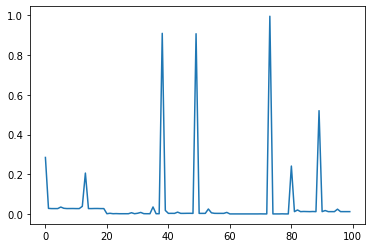

In [195]:
aml_model_2=AML_model2(100,100,100,128,2,5,shared=False, attention=True,expand=False).to(device)
aml_model_2.load_state_dict(torch.load("./model_checkpoints_at/model_his_aml.pt"))
plt.plot(aml_model_2(train_data["input"].to(device))[2][1].cpu().detach().numpy())

In [204]:
pred_2=[]
for idx,test_data in enumerate(test_encoded_loader):
    pred_2_q=aml_model_2(test_data["input"].to(device))[0].item()
    pred_2.append(pred_2_q)
#RUL
path = DATA_PATH+'RUL.csv'
RUL_frame = pd.read_csv(path, header=None)
RUL = RUL_frame.values[:, 0]
RUL_y=pd.Series(RUL)
RUL_y.index+=1
np.sum(np.ceil((abs(np.array(pred_2)-RUL))))#目测结果

2368.0

In [205]:
np.where(np.ceil((abs(np.array(pred_2)-RUL)))>50)

(array([12, 27, 31, 35, 36, 41, 46, 48, 51, 53, 60, 68, 96], dtype=int64),)

In [206]:
lifetime_list=[]
for i in range(len(test_dataset)):
    lifetime=test_dataset[i]["lifetime"].item()
    lifetime_list.append(lifetime)
lifetime_list=np.array(lifetime_list)

In [207]:
np.where(np.ceil((abs(np.array(pred_2)-RUL)))>80)

(array([12, 31, 41, 46, 51, 60, 96], dtype=int64),)

In [208]:
lifetime_list[np.where(np.ceil((abs(np.array(pred_2)-RUL)))>80)]

array([ 65, 120,  87,  56,  38,  78,  95])

In [209]:
np.where(lifetime_list<100)

(array([ 3,  5, 12, 27, 28, 35, 36, 41, 44, 46, 51, 53, 60, 64, 69, 73, 79,
        83, 87, 90, 96], dtype=int64),)

In [210]:
def get_Accuracy(hat_RUL, RUL_true, lifetime_list):
    """

    :return: RUL升序排序后前20个，前40个，前**个的误差
    """
    # hat_RUL = get_RUL(mu_Gamma, C_Gamma, sigma_2, w, data, data_train)
    # RUL_frame = pd.read_csv(path, header=None)
    # RUL = RUL_frame.values[:, 0]
    Accuracy = np.zeros((100, 2))
    Accuracy[:, 0] = RUL_true
    Accuracy[:, 1] = abs(hat_RUL - RUL_true) / (lifetime_list + RUL_true)
    num_A = np.argsort(Accuracy[:, 0])
    iAccuracy = np.zeros((100, 2))
    for ia in range(0, 100):
        iAccuracy[ia, 0] = Accuracy[int(num_A[ia]), 0]
        iAccuracy[ia, 1] = Accuracy[int(num_A[ia]), 1]
    rul0 = [25, 50, 75, 100, 125, 300]
    Accuracy_RUL = np.mat(np.zeros((6, 3)))
    for ir in range(0, 6):
        Accuracy_RUL[ir, 0] = int(rul0[ir])
        num_rul = np.argwhere((iAccuracy[:, 0] <= rul0[ir]))
        #(cycletime_sim_raw > 50) & (cycletime_sim_raw < 350)
        Accuracy_RUL[ir, 1] = np.mean(iAccuracy[num_rul[:, 0], 1])
        s_error = np.std(iAccuracy[num_rul[:, 0], 1])/math.sqrt(len(num_rul))
        Accuracy_RUL[ir, 2] = s_error
    Accuracy_RUL[5, 0] = 150
    return Accuracy_RUL

In [211]:
get_Accuracy(np.array(pred_2), RUL,lifetime_list)

matrix([[2.50000000e+01, 1.99635571e-02, 5.89919628e-03],
        [5.00000000e+01, 2.19749984e-02, 4.33802086e-03],
        [7.50000000e+01, 5.09131713e-02, 1.31361999e-02],
        [1.00000000e+02, 7.17816508e-02, 1.32667151e-02],
        [1.25000000e+02, 9.70969080e-02, 1.67776799e-02],
        [1.50000000e+02, 1.13511552e-01, 1.72295551e-02]])